In [2]:

from pathlib import Path

import numpy as np
import pandas as pd
from joblib import Memory
from pyriemann.tangentspace import TangentSpace
from scipy.signal import savgol_filter, welch
from scipy.stats import kurtosis, skew
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       f_regression)
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm

from pipeline_utils import (BorutaTransformer, CovarianceVectorizer,
                            DummyTrainMeanStorer, ListPSDTransformer,
                            ListSavgol, ListSNV, ListSpectralBinner,
                            MeanSpectralAggregator, PLSFeatureExtractor,
                            SavgolTransformer, SNVTransformer, SpectralBinner,
                            VariableSizeCovariance, mse_ratio_to_dummy_scorer)

In [6]:
def load_raw_list_dataset(n_subsamples=10, pixels_per_sample=150, bin_factor=3):
    DATASET_DIR = Path('data/SeeingBeyondTheVisible')
    TRAIN_DIR = DATASET_DIR / 'train_data' / 'train_data'
    CSV_PATH = DATASET_DIR / 'train_data' / 'train_gt.csv'
    
    files = sorted(TRAIN_DIR.glob('*.npz'))
    ydf_raw = pd.read_csv(CSV_PATH).set_index('sample_index')
    
    X_list = []
    y_list = []
    groups = []
    
    for file_name in tqdm(files, desc="Augmenting data"):
        # Wyciągamy ID próbki z nazwy pliku (np. "123.npz" -> 123)
        sample_id = int(file_name.stem)
        
        if sample_id not in ydf_raw.index:
            continue
            
        with np.load(file_name) as npz:
            data, mask = npz['data'], npz['mask']
            
            # 1. Normalizacja i Binning spektralny
            # Bands, W, H
            B, W, H = data.shape 
            
            if mask.ndim == 3:
                spatial_mask = mask[0, :, :] # bierzemy maskę z pierwszego kanału
            else:
                spatial_mask = mask
                
            # 3. Binning spektralny
            new_B = B // bin_factor
            data_binned = data[:new_B*bin_factor].reshape(new_B, bin_factor, W, H).mean(axis=1)
            data_binned /= 2210.0
            
            # 4. Spłaszczanie
            img_flat = data_binned.reshape(new_B, -1)  # Kształt: (new_B, W*H) -> (new_B, 121)
            mask_flat = spatial_mask.reshape(-1)        # Kształt: (W*H) -> (121)
            
            # 5. Indeksowanie (Teraz 121 pasuje do 121!)
            valid_pixels = img_flat[:, ~mask_flat]
            valid_pixels = valid_pixels.T
            n_valid = valid_pixels.shape[0]
            
            current_subsamples = []
            if n_valid < pixels_per_sample:
                 current_subsamples.append(valid_pixels)
            else:
                for _ in range(n_subsamples):
                    idx = np.random.choice(n_valid, pixels_per_sample, replace=False)
                    current_subsamples.append(valid_pixels[idx, :])

            for subsample in current_subsamples:
                X_list.append(subsample.astype(np.float32))
                y_list.append(ydf_raw.loc[sample_id])
                groups.append(sample_id)

    return X_list, pd.DataFrame(y_list), np.array(groups)

# class SpectralListDataManager:
#     def __init__(self, target_column='P'):
#         self.X_cache = None # To będzie lista
#         self.y_cache = None
#         self.groups_cache = None
#         self.target_column = target_column
        
#     def load_base_data(self):
#         self.X_cache, self.y_cache, self.groups_cache = load_raw_list_dataset(
#             n_subsamples=5, pixels_per_sample=150
#         )

#     def get_data(self, mode='full'):
#         if self.X_cache is None: self.load_base_data()
        
#         y_vec = self.y_cache[self.target_column].values
        
#         if mode == 'augmented':
#             return self.X_cache, y_vec, self.groups_cache
        
#         elif mode == 'subsample':
#             # Filtrowanie listy i tablic numpy
#             mask = np.random.rand(len(self.groups_cache)) < 0.3
#             # List comprehension dla X (bo to lista pythonowa)
#             X_sub = [x for i, x in enumerate(self.X_cache) if mask[i]]
#             return X_sub, y_vec[mask], self.groups_cache[mask]

class SpectralListDataManager:
    def __init__(self, target_column='P'):
        if isinstance(target_column, str):
            self.target_columns = [target_column]
        else:
            self.target_columns = target_column
            
        self.X_cache = None
        self.y_df_cache = None
        self.groups_cache = None
        
    def load_base_data(self):
        self.X_cache, self.y_df_cache, self.groups_cache = load_raw_list_dataset(
            n_subsamples=5, pixels_per_sample=150
        )

    def get_data(self, mode='full'):
        """
        Zwraca dane gotowe do treningu, przefiltrowane pod kątem NaN w targetach.
        """
        if self.X_cache is None: 
            self.load_base_data()
        
        # 1. Wybierz tylko interesujące nas kolumny
        # .copy() jest ważne!! by nie modyfikować oryginału w cache
        y_subset = self.y_df_cache[self.target_columns].copy()
        
        # 2. Obsługa brakujących danych (NaN) - KLUCZOWE DLA MULTI-OUTPUT
        valid_mask = y_subset.notna().all(axis=1)
        
        # Jeśli są jakieś braki, musimy zsynchronizować usunięcie danych z X i groups
        if not valid_mask.all():
            # Konwersja maski pandas na numpy dla bezpieczeństwa
            valid_mask_np = valid_mask.values
            y_final = y_subset.loc[valid_mask].values 
            groups_final = self.groups_cache[valid_mask_np]
            X_final = [x for x, is_valid in zip(self.X_cache, valid_mask_np) if is_valid]
        else:
            y_final = y_subset.values
            groups_final = self.groups_cache
            X_final = self.X_cache

        if y_final.shape[1] == 1:
            y_final = y_final.ravel()

        # 3. Obsługa trybów eksperymentalnych (augmented / subsample)
        if mode == 'augmented' or mode == 'full':
            return X_final, y_final, groups_final
        
        elif mode == 'subsample':
            n_samples = len(X_final)
            rng = np.random.RandomState(42) 
            subsample_mask = rng.rand(n_samples) < 0.3
            
            # Aplikacja maski
            X_sub = [x for i, x in enumerate(X_final) if subsample_mask[i]]
            y_sub = y_final[subsample_mask]
            groups_sub = groups_final[subsample_mask]
            
            return X_sub, y_sub, groups_sub
        
        else:
            raise ValueError(f"Unknown mode: {mode}")

In [3]:
location = './cachedir'
memory = Memory(location=location, verbose=0)

In [4]:
main_pipeline = Pipeline([
    ('storer', DummyTrainMeanStorer()),
    ('binner', ListSpectralBinner()),
    ('snv', 'passthrough'),
    ('savgol', 'passthrough'),
    ('feature_extraction', 'passthrough'),
    ('vectorizer', 'passthrough'),
    ('dim_reduction', 'passthrough'),
    ('scaler', 'passthrough'),
    ('estimator', Ridge()),
], memory=memory)

cov_psd_block = FeatureUnion([
    ('cov_path', Pipeline([
        ('cov_est', VariableSizeCovariance(estimator='lwf')),
        ('vectorizer', TangentSpace(metric='riemann'))
    ])),
    ('psd_path', ListPSDTransformer(n_per_seg=10))
])

param_grid = [
    # mój baseline model
    {
        'regressor__binner': [ListSpectralBinner(bin_factor=1)], # Pełna rozdzielczość dla średniej
        'regressor__snv': [ListSNV(), 'passthrough'],
        'regressor__savgol': [ListSavgol(deriv=0), ListSavgol(deriv=1)],
        'regressor__feature_extraction': [MeanSpectralAggregator()],
        'regressor__dim_reduction': [
            'passthrough', 
            PLSFeatureExtractor(n_components=20), 
            PLSFeatureExtractor(n_components=30),
            PCA(n_components=20),
            PCA(n_components=30)
        ],
        'regressor__estimator__min_samples_leaf': [3,5],
        'regressor__estimator': [RandomForestRegressor(n_estimators=300)],
    },

    # --- 1. Podejście: Średnia + PCA/PLSFeatureExtractor + RF ---
    {
        'regressor__binner': [ListSpectralBinner(bin_factor=1)], # Pełna rozdzielczość dla średniej
        'regressor__feature_extraction': [MeanSpectralAggregator()],
        'regressor__dim_reduction': [PLSFeatureExtractor(n_components=20), PCA(n_components=20)],
        'regressor__estimator': [RandomForestRegressor(n_estimators=300, min_samples_leaf=4,  random_state=42)]
    },
    
    # --- 2. Podejście: Kowariancja (Euklidesowa) + RF ---
    {
        'regressor__binner': [ListSpectralBinner(bin_factor=15), ListSpectralBinner(bin_factor=5)], # bin_factor=15 dla szybkości
        'regressor__feature_extraction': [VariableSizeCovariance(estimator='lwf')],
        'regressor__vectorizer': [CovarianceVectorizer()],
        'regressor__estimator': [RandomForestRegressor(n_estimators=300, random_state=42)],
    },
    
    # --- 3. Podejście: pyRiemann (Tangent Space) + Ridge ---
    {
        'regressor__binner': [ListSpectralBinner(bin_factor=15), ListSpectralBinner(bin_factor=5)],
        'regressor__feature_extraction': [VariableSizeCovariance(estimator='lwf')],
        'regressor__vectorizer': [TangentSpace(metric='riemann')],
        'regressor__scaler': [StandardScaler(), MinMaxScaler()],
        'regressor__estimator__alpha': [0.01, 1, 10],
        'regressor__dim_reduction': ['passthrough', PLSFeatureExtractor(n_components=20), PCA(n_components=20), RFE(estimator=RandomForestRegressor())],
        'regressor__estimator': [Ridge(), ElasticNet(l1_ratio=.75)]
    },

    # --- 4. Podejście: Union kowariancji i standardowego feature engineeringu ---
    {
        'regressor__binner': [ListSpectralBinner(bin_factor=15), ListSpectralBinner(bin_factor=5)],
        'regressor__feature_extraction': [cov_psd_block], 
        'regressor__snv': ['passthrough'],     
        'regressor__savgol': ['passthrough'], 
        'regressor__dim_reduction': [
            'passthrough',
             PLSFeatureExtractor(n_components=30),
             PCA(n_components=30),
             RFE(estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1), n_features_to_select=75),
             BorutaTransformer(max_iter=50),
             SelectKBest(score_func=f_regression, k=50),
             SelectFromModel(estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1), 
                               max_features=50, threshold=-np.inf)
             ],
        'regressor__estimator': [RandomForestRegressor(n_estimators=300, random_state=42)]
    },
    # --- 5. proste podejście ---
    {
        'regressor__binner': [ListSpectralBinner(bin_factor=15), ListSpectralBinner(bin_factor=3)],
        'regressor__feature_extraction': ['passthrough'],
        'regressor__snv': [ListSNV(), 'passthrough'],
        'regressor__savgol': [ListSavgol(deriv=1), ListSavgol(deriv=0)],
        'regressor__dim_reduction': [PLSFeatureExtractor(n_components=20)],
        'regressor__estimator': [RandomForestRegressor(n_estimators=300, random_state=42)]
    }
]

In [7]:
manager = SpectralListDataManager(target_column=['P','K','Mg','pH'])
X_list, y, groups = manager.get_data(mode='augmented')

Augmenting data:   1%|          | 20/1732 [00:00<00:08, 192.83it/s]

Augmenting data: 100%|██████████| 1732/1732 [00:25<00:00, 67.57it/s] 


In [8]:
final_pipeline = TransformedTargetRegressor(
    regressor=main_pipeline,
    transformer=StandardScaler() # Skalowanie y -> multioutput, skośne rozłady.
)

gkf = GroupKFold(n_splits=5)

grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=gkf,
    scoring='neg_mean_squared_error', # mse_ratio_to_dummy_scorer,
    n_jobs=-1,
    verbose=1,
    error_score='raise', # rzuc błędem, nie wstawiaj NaN!
)

# Start eksperymentu
grid_search.fit(X_list, y, groups=groups)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/home/katarzyna/cv_env/lib/python3.10/site-packages/joblib/memory.py:607: UserWarning: Persisting input arguments took 2.63s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]
/home/katarzyna/cv_env/lib/python3.10/site-packages/joblib/memory.py:607: UserWarning: Persisting input arguments took 3.32s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]
/home/katarzyna/cv_env/lib/python3.10/site-packages/joblib/memory.py:607: UserWarning: Persisting input arguments took 2.94s to run.If this happens often in your code, it can cause performance problems (results will be correct in 

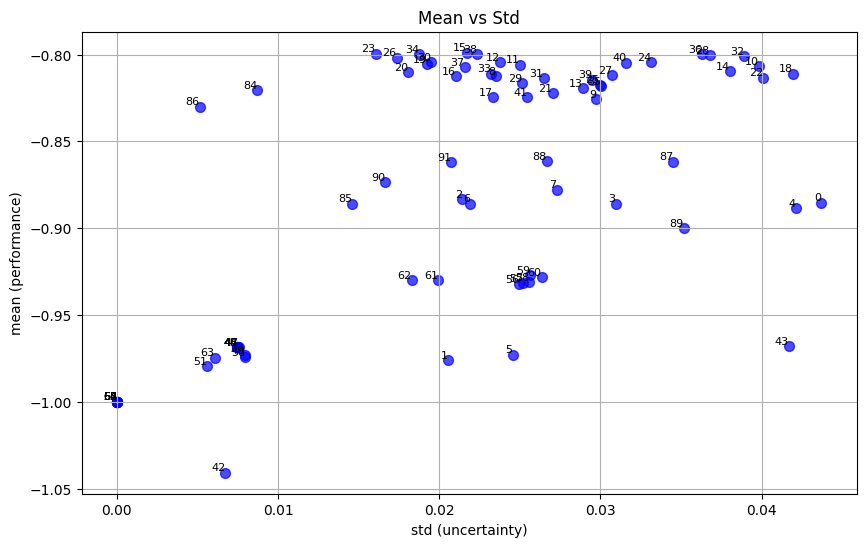

In [113]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(grid_search.cv_results_)

x = results_df["std_test_score"].values
y = results_df["mean_test_score"].values
labels = results_df.index.astype(str)  # lub inna kolumna, jeśli chcesz np. numer eksperymentu

plt.figure(figsize=(10,6))
plt.scatter(x, y, s=50, color="blue", alpha=0.7)

# dodanie numerów przy punktach
for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, fontsize=8, ha='right', va='bottom')

plt.xlabel("std (uncertainty)")
plt.ylabel("mean (performance)")
plt.title("Mean vs Std")
plt.grid(True)
plt.show()


In [108]:
results_df.loc[23]['params']

{'regressor__binner': ListSpectralBinner(),
 'regressor__dim_reduction': PLSFeatureExtractor(n_components=30),
 'regressor__estimator': RandomForestRegressor(n_estimators=300),
 'regressor__estimator__min_samples_leaf': 5,
 'regressor__feature_extraction': MeanSpectralAggregator(),
 'regressor__savgol': ListSavgol(deriv=1),
 'regressor__snv': 'passthrough'}

In [109]:
results_df.loc[84]['params']

{'regressor__binner': ListSpectralBinner(bin_factor=3),
 'regressor__dim_reduction': 'passthrough',
 'regressor__estimator': RandomForestRegressor(n_estimators=300, random_state=42),
 'regressor__feature_extraction': FeatureUnion(transformer_list=[('cov_path',
                                 Pipeline(steps=[('cov_est',
                                                  VariableSizeCovariance()),
                                                 ('vectorizer',
                                                  TangentSpace())])),
                                ('psd_path', ListPSDTransformer(n_per_seg=16))]),
 'regressor__savgol': ListSavgol(deriv=1),
 'regressor__snv': ListSNV()}